In [1]:
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
df = pd.read_csv('/Users/dorris.wong//Downloads/sTEF.csv')

In [3]:
df.describe()

#this doesn't tell us anything since it's showing us information about the index and vehicle year, 
#meaning we only have 2 numeric columns and the rest are categorical

,id,vehicle_year
count,54681.000000,13223.000000
mean,27341.000000,2010.568025
std,15785.189372,35.219184
min,1.000000,0.000000
25%,13671.000000,2008.000000
50%,27341.000000,2013.000000
75%,41011.000000,2015.000000
max,54681.000000,2017.000000


In [4]:
df.head()

#there are NaN

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016,NaN


In [5]:
df.isnull().sum()

#there are 3 columns with close to or over 50% with Nulls

id                          0
city_name                   0
signup_os                6857
signup_channel              0
signup_date                 0
bgc_date                21785
vehicle_added_date      41547
vehicle_make            41458
vehicle_model           41458
vehicle_year            41458
first_completed_date    48544
dtype: int64

In [6]:
#create response variable for prediction

df['first_ride'] =  df['first_completed_date'].map(lambda x: 1 if pd.notnull(x) else 0)

In [7]:
df.groupby('city_name').first_ride.mean()#Berton residents more likely to be drivers

city_name
Berton     0.121141
Strark     0.109585
Wrouver    0.092071
Name: first_ride, dtype: float64

In [8]:
df.groupby('signup_os').first_ride.mean() #mac users are more likely to become drivers

signup_os
android web    0.097297
ios web        0.131734
mac            0.162775
other          0.136513
windows        0.132527
Name: first_ride, dtype: float64

In [9]:
df.groupby('signup_channel').first_ride.mean() #referral signups are more likely to become drivers

signup_channel
Organic     0.090117
Paid        0.061910
Referral    0.198949
Name: first_ride, dtype: float64

In [10]:
#we can't predict on only categorical variables so we will need to create new variables

#just having dates won't have any substantial meaning, I am going to create new variables with date difference
df['vehicle_added_date']=pd.to_datetime(df['vehicle_added_date'])
df['bgc_date']=pd.to_datetime(df['bgc_date'])
df['signup_date']=pd.to_datetime(df['signup_date'])
df['first_completed_date']=pd.to_datetime(df['first_completed_date'])

df['car_diff'] = df['first_completed_date']-df['vehicle_added_date']
df['bgc_diff'] = df['first_completed_date']-df['bgc_date']
df['signup_dow'] = df['signup_date'].dt.dayofweek
df['first_ride_dow'] = df['first_completed_date'].dt.dayofweek

#creating dummies
dummies = pd.get_dummies(df['city_name']).rename(columns=lambda x:str(x))
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['signup_os']).rename(columns=lambda x:str(x))
df = pd.concat([df, dummies], axis=1)

dummies = pd.get_dummies(df['signup_channel']).rename(columns=lambda x:str(x))
df = pd.concat([df, dummies], axis=1)

df['vehicle_year'].fillna(0, inplace=True)

In [11]:
df['luxury_car'] = np.where( df['vehicle_make'].isin(['Mercedes-Benz', 'Lexus', 'Audi','BMW','Land Rover'\
                                                     ,'Hummer','Porsche','Tesla','Jaguar','Mini','Maserati'\
                                                     ,'Bentley']) , 1, 0)

In [12]:
df['new_car'] = np.where( df['vehicle_year']>=2006, 1, 0)

In [13]:
#need to encode the categorical variables, won't make sense to fill the nulls with 0's

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df.vehicle_model)
df.vehicle_model=le.transform(df.vehicle_model) 

le.fit(df.vehicle_make)
df.vehicle_make=le.transform(df.vehicle_make) 

le.fit(df.city_name)
df.city_name=le.transform(df.city_name) 

le.fit(df.signup_os)
df.signup_os=le.transform(df.signup_os)

le.fit(df.signup_channel)
df.signup_channel=le.transform(df.signup_channel) 

/Users/dorris.wong/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/Users/dorris.wong/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [14]:
#Need to take care of the NaT values
from datetime import timedelta

#using 0 would affect our analysis, thereforce using the mean of each column to fill in the nulls
df.car_diff.fillna(df.car_diff.mean(),inplace=True)
df.bgc_diff.fillna(df.bgc_diff.mean(),inplace=True)
df.first_ride_dow.fillna(df.first_ride_dow.mean(),inplace=True)

df['car_diff']=(df.car_diff / np.timedelta64(1, 'D')).astype(int)
df['bgc_diff']=(df.bgc_diff / np.timedelta64(1, 'D')).astype(int)

In [15]:
df.cov()

,id,city_name,signup_os,signup_channel,vehicle_make,vehicle_model,vehicle_year,first_ride,car_diff,bgc_diff,...,android web,ios web,mac,other,windows,Organic,Paid,Referral,luxury_car,new_car
id,2.491722e+08,14.129901,-157.983778,95.866825,-1764.134199,-9049.521452,-153111.860461,-4.663630e+01,266.315655,199.601628,...,-1.515106,25.850969,-15.936668,-10.236686,-23.882772,-69.606492,43.346159,26.260333,-17.711686,-70.687399
city_name,1.412990e+01,0.383114,-0.005786,-0.018441,-0.150180,-0.678386,-11.330789,-5.123681e-03,0.002097,0.004293,...,0.003904,-0.009420,-0.003121,0.003201,0.001141,0.003151,0.012139,-0.015290,-0.000744,-0.001225
signup_os,-1.579838e+02,-0.005786,2.255896,-0.140960,1.759015,10.841446,128.092559,4.298473e-02,0.029898,0.041187,...,-0.297240,-0.026645,0.097180,0.127587,0.360908,0.003709,0.133542,-0.137251,0.007349,0.055648
signup_channel,9.586683e+01,-0.018441,-0.140960,0.557176,1.420412,7.779600,101.424500,3.289186e-02,0.004292,0.005081,...,0.008013,0.012292,-0.014580,-0.008750,-0.018963,-0.263020,-0.031136,0.294156,0.004067,0.045271
vehicle_make,-1.764134e+03,-0.150180,1.759015,1.420412,171.963470,834.043442,9784.849486,2.170181e+00,1.949473,1.557924,...,-0.137525,0.328938,0.250955,0.042955,0.062796,-0.185414,-1.049585,1.234999,0.266692,4.287484
vehicle_model,-9.049521e+03,-0.678386,10.841446,7.779600,834.043442,7187.215657,58350.930477,1.286673e+01,12.542685,11.781466,...,-0.590744,1.546991,1.409344,0.448956,0.462871,-0.999480,-5.780641,6.780121,1.662110,25.392941
vehicle_year,-1.531119e+05,-11.330789,128.092559,101.424500,9784.849486,58350.930477,741458.162688,1.614750e+02,148.733159,125.790791,...,-8.233865,24.520421,15.742710,4.049893,4.771576,-12.503453,-76.417594,88.921047,34.719321,322.805631
first_ride,-4.663630e+01,-0.005124,0.042985,0.032892,2.170181,12.866734,161.475049,9.963840e-02,0.086585,0.069667,...,-0.004082,0.005932,0.005383,0.001620,0.002515,-0.005431,-0.022031,0.027461,0.007336,0.072420
car_diff,2.663157e+02,0.002097,0.029898,0.004292,1.949473,12.542685,148.733159,8.658491e-02,3.793944,3.465006,...,0.010160,-0.009238,-0.002323,0.006332,0.003971,0.000996,-0.006285,0.005289,0.001143,0.066130
bgc_diff,1.996016e+02,0.004293,0.041187,0.005081,1.557924,11.781466,125.790791,6.966732e-02,3.465006,5.257101,...,0.015349,-0.010226,-0.004682,0.005866,0.007375,-0.005389,0.005697,-0.000308,-0.001002,0.058237


In [16]:
df.corr() #variable dependencies 

,id,city_name,signup_os,signup_channel,vehicle_make,vehicle_model,vehicle_year,first_ride,car_diff,bgc_diff,...,android web,ios web,mac,other,windows,Organic,Paid,Referral,luxury_car,new_car
id,1.000000,0.001446,-0.006664,0.008136,-0.008522,-0.006762,-0.011265,-9.359679e-03,0.008662,0.005515,...,-0.000215,0.003560,-0.003273,-0.002599,-0.004592,-0.010245,0.005535,0.003576,-0.007519,-0.010965
city_name,0.001446,1.000000,-0.006224,-0.039914,-0.018502,-0.012928,-0.021259,-2.622436e-02,0.001739,0.003025,...,0.014153,-0.033080,-0.016345,0.020728,0.005597,0.011827,0.039532,-0.053104,-0.008057,-0.004845
signup_os,-0.006664,-0.006224,1.000000,-0.125730,0.089308,0.085143,0.099042,9.066534e-02,0.010220,0.011960,...,-0.444068,-0.038561,0.209738,0.340428,0.729276,0.005737,0.179214,-0.196440,0.032790,0.090723
signup_channel,0.008136,-0.039914,-0.125730,1.000000,0.145111,0.122936,0.157799,1.395978e-01,0.002952,0.002969,...,0.024088,0.035793,-0.063315,-0.046978,-0.077104,-0.818659,-0.084078,0.847145,0.036512,0.148508
vehicle_make,-0.008522,-0.018502,0.089308,0.145111,1.000000,0.750223,0.866548,5.242815e-01,0.076323,0.051815,...,-0.023532,0.054524,0.062035,0.013127,0.014533,-0.032850,-0.161330,0.202453,0.136287,0.800592
vehicle_model,-0.006762,-0.012928,0.085143,0.122936,0.750223,1.000000,0.799326,4.808113e-01,0.075956,0.060610,...,-0.015636,0.039664,0.053888,0.021223,0.016570,-0.027391,-0.137439,0.171923,0.131383,0.733431
vehicle_year,-0.011265,-0.021259,0.099042,0.157799,0.866548,0.799326,1.000000,5.940852e-01,0.088679,0.063714,...,-0.021457,0.061898,0.059264,0.018849,0.016818,-0.033736,-0.178882,0.221992,0.270202,0.917961
first_ride,-0.009360,-0.026224,0.090665,0.139598,0.524281,0.480811,0.594085,1.000000e+00,0.140826,0.096259,...,-0.029018,0.040846,0.055283,0.020566,0.024180,-0.039972,-0.140678,0.187017,0.155752,0.561786
car_diff,0.008662,0.001739,0.010220,0.002952,0.076323,0.075956,0.088679,1.408262e-01,1.000000,0.775863,...,0.011704,-0.010309,-0.003866,0.013027,0.006188,0.001188,-0.006504,0.005837,0.003931,0.083134
bgc_diff,0.005515,0.003025,0.011960,0.002969,0.051815,0.060610,0.063714,9.625928e-02,0.775863,1.000000,...,0.015022,-0.009695,-0.006620,0.010252,0.009762,-0.005460,0.005008,-0.000289,-0.002928,0.062194


In [17]:
print df[df['first_completed_date'].notnull()].id.count()/df.id.count()

#11% of the signups took a first trip
#definitely an imbalance in the dataset

0.112232768238


In [18]:
from sklearn.linear_model import LogisticRegression

feature_cols = ['Berton', 'Strark','Wrouver',\
                'android web','ios web','mac','other','windows', \
                'Organic','Paid','Referral','car_diff','bgc_diff','signup_dow','first_ride_dow' \
               , 'vehicle_model','vehicle_make','vehicle_year','luxury_car','new_car']

X = df[feature_cols]
y = df.first_ride

logreg = LogisticRegression()
logreg.fit(X, y)
zip(feature_cols, logreg.coef_[0])

#vehicle_model, vehicle_make, and vehicle_year have little effect on whether a driver makes a first rideb

[('Berton', -1.1315249792774575),
 ('Strark', -1.2281477660341225),
 ('Wrouver', -1.3043218801233638),
 ('android web', 0.80655209548108331),
 ('ios web', 0.97351021575924568),
 ('mac', 1.2612066154372719),
 ('other', 1.2146747494663406),
 ('windows', 1.2405235961984893),
 ('Organic', -1.348319811071822),
 ('Paid', -1.4945022206721821),
 ('Referral', -0.82117259369369933),
 ('car_diff', 0.078510597587144626),
 ('bgc_diff', -0.016364426601295366),
 ('signup_dow', -0.018106718124487695),
 ('first_ride_dow', -0.0089865539804125684),
 ('vehicle_model', 0.00021552700630901277),
 ('vehicle_make', 0.0020178130036056789),
 ('vehicle_year', 0.0020853508754929218),
 ('luxury_car', 0.0268211809267376),
 ('new_car', 0.31416034345893229)]

In [19]:
#let's run a Recursive Feature Elemination as well to check for features to use in our model

from sklearn.feature_selection import RFE

rfe = RFE(logreg, 16)
fit = rfe.fit(X, y)

zip(feature_cols, fit.ranking_)

#this affirms the lack of importance of vehicle_model, vehicle_make, and vehicle_yearb

[('Berton', 1),
 ('Strark', 1),
 ('Wrouver', 1),
 ('android web', 1),
 ('ios web', 1),
 ('mac', 1),
 ('other', 1),
 ('windows', 1),
 ('Organic', 1),
 ('Paid', 1),
 ('Referral', 1),
 ('car_diff', 1),
 ('bgc_diff', 2),
 ('signup_dow', 1),
 ('first_ride_dow', 3),
 ('vehicle_model', 5),
 ('vehicle_make', 1),
 ('vehicle_year', 4),
 ('luxury_car', 1),
 ('new_car', 1)]

In [20]:
#I'm going to leave in the irrelevant variables since doing regularization would automatically zero
#the coefficents. I could remove them and run my logreg, but it isn't necessary. There is dependency on the variables and 
#would better to leave them in

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

from sklearn import metrics
from sklearn.cross_validation import cross_val_score
print metrics.accuracy_score(y_test, y_pred)
print cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.897227708288
0.92458250717


In [21]:
#finding best params

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

pipe = make_pipeline(StandardScaler(), LogisticRegression())
C_range = 10.**np.arange(-2, 3)
penalty_options = ['l1', 'l2']
param_grid = dict(logisticregression__C=C_range, logisticregression__penalty=penalty_options)
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc')
grid.fit(X, y)
grid.best_score_
grid.best_params_

#C being 100 meaning the lambda is small so less weight on penalty for outliers
#l1 is robust, it helps minimize the outliers in this case the irrelevant dependent variables

{'logisticregression__C': 100.0, 'logisticregression__penalty': 'l1'}

In [22]:
logreg = LogisticRegression(C=100.0, penalty='l1')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print metrics.accuracy_score(y_test, y_pred)
print cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.896715675518
0.924671546286


In [23]:
zip(feature_cols, logreg.coef_[0])

#all my coefficents are negative, this is where i'm getting stuck as to why

[('Berton', -2.6872868635429996),
 ('Strark', -2.7969929022299764),
 ('Wrouver', -2.9126474831072313),
 ('android web', 0.87934691954009347),
 ('ios web', 1.0761758615138317),
 ('mac', 1.3681302699383322),
 ('other', 1.3050820864573993),
 ('windows', 1.3609423371764258),
 ('Organic', -1.7800657900844774),
 ('Paid', -1.9193070769156477),
 ('Referral', -1.2173880564004933),
 ('car_diff', 0.083703533393056695),
 ('bgc_diff', -0.019456491166858991),
 ('signup_dow', -0.013068705121960303),
 ('first_ride_dow', -0.011084640362014408),
 ('vehicle_model', 0.00022248453275012562),
 ('vehicle_make', 0.00072966714269443996),
 ('vehicle_year', 0.0021125874999776109),
 ('luxury_car', 0.0066653800163537962),
 ('new_car', 0.32763062271190335)]

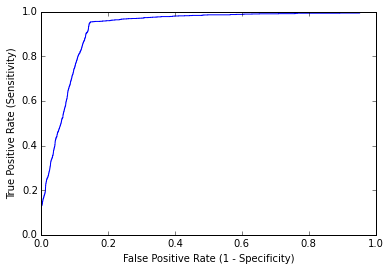

In [24]:
probs = logreg.predict_proba(X_test)[:, 1]

# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [25]:
#run a confusion matrix

from sklearn.metrics import confusion_matrix
print confusion_matrix(y_test, y_pred)

[[11685   463]
 [  949   574]]
